# DUC Datathon 2020
## Predicting Total Vertical Depth

In this section of the competition we are tasked with building regression machine learning (or other)
model that will be able to predict TVD (True Vertical Depth)

In [3]:
# import general libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# import prediction libraries
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
# for polynomial feature extraction
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import BaseEstimator, TransformerMixin


### Data import

In [4]:
# import well header data
well_header = pd.read_csv("../data/WellHeader_Datathon.csv")

In [5]:
well_header.shape

(10437, 89)

In [6]:
well_header.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10437 entries, 0 to 10436
Data columns (total 89 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   EPAssetsId                 10437 non-null  int64  
 1   Province                   10437 non-null  object 
 2   LicenceNumber              10437 non-null  object 
 3   UWI                        10437 non-null  object 
 4   CurrentOperator            10437 non-null  object 
 5   CurrentOperatorParent      10437 non-null  int64  
 6   CurrentOperatorParentName  10437 non-null  object 
 7   Licensee                   10437 non-null  object 
 8   LicenseeParentCompany      10437 non-null  int64  
 9   LicenseeParentCompanyName  10437 non-null  object 
 10  LicenceDate                10437 non-null  object 
 11  CurrentStatus              10437 non-null  object 
 12  CurrentStatusStandardised  10437 non-null  object 
 13  WellType                   10437 non-null  obj

Take a random sample with selected columns

In [27]:
well_header[['EPAssetsId','TVD','TotalDepth',
             'Surf_Longitude',"Surf_Latitude",
             'WellProfile','KBElevation'
             ]].sample(20)

,EPAssetsId,TVD,TotalDepth,Surf_Longitude,Surf_Latitude,WellProfile,KBElevation
6750,1152200,NaN,1763.0,-109.968366,51.751350,Horizontal,719.9
5516,1161378,737.08,1962.0,-109.031132,51.506043,Horizontal,709.6
3246,2588003,3224.96,6222.0,-118.678222,54.516190,Horizontal,978.9
5352,1171060,NaN,1475.0,-107.943523,51.087228,Horizontal,689.7
9810,2609114,2259.93,4990.0,-113.395544,51.850214,Horizontal,892.6
10287,2588148,1440.80,3616.0,-114.770469,53.114763,Horizontal,868.2
8306,42067,NaN,5140.0,-120.534236,55.904597,Horizontal,713.7
8434,40734,NaN,3573.0,-120.034392,55.955150,Horizontal,638.1
8209,42346,NaN,5685.0,-120.075728,55.668967,Horizontal,809.8
3082,2621766,3720.00,3720.0,-118.550085,54.296891,Vertical,1187.3


### Total counts for some of the variables:

In [11]:
well_header.Formation.value_counts()

Viking      5208
Montney     3395
Cardium     1147
Duvernay     687
Name: Formation, dtype: int64

In [12]:
well_header.Pool.value_counts()

Montney A             1765
Dodsland Viking        955
Commingled MFP9515     776
Montney Undefined      766
Viking                 693
                      ... 
Duvernay L2L             1
Montney E4E              1
Duvernay ZZ              1
Montney Q8Q              1
Montney S5S              1
Name: Pool, Length: 412, dtype: int64

In [13]:
well_header.Field.value_counts()

Heritage                          1158
Dodsland                           955
Provost                            783
Viking  - Miscellaneous Area 2     689
Northern Montney                   573
                                  ... 
Workman (AB)                         1
Muskrat                              1
Oungre South                         1
Bonanza                              1
Berland River West                   1
Name: Field, Length: 136, dtype: int64

There are only 6 vertical wells and one is missing the TVD.

In [14]:
well_header.WellProfile.value_counts()

Horizontal     8621
Directional    1810
Vertical          6
Name: WellProfile, dtype: int64

In [15]:
well_header[well_header['WellProfile']=='Vertical'][['EPAssetsId','TVD','TotalDepth']]

,EPAssetsId,TVD,TotalDepth
1565,2587216,892.0,892.0
2449,2583033,1133.0,1133.0
3082,2621766,3720.0,3720.0
3119,2620152,3450.0,3450.0
3150,2597923,2000.0,2000.0
7773,41005,NaN,1970.0


### Data Exploration

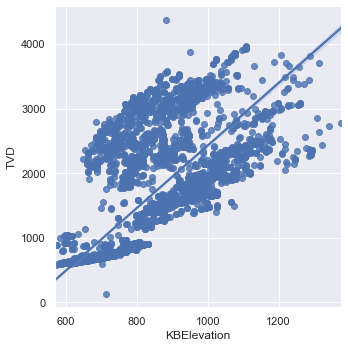

In [34]:
sns.set()
sns.lmplot( x="KBElevation", y="TVD", 
            # hue = 'WellProfile',
            data=well_header, fit_reg=True, height= 5, legend=True);

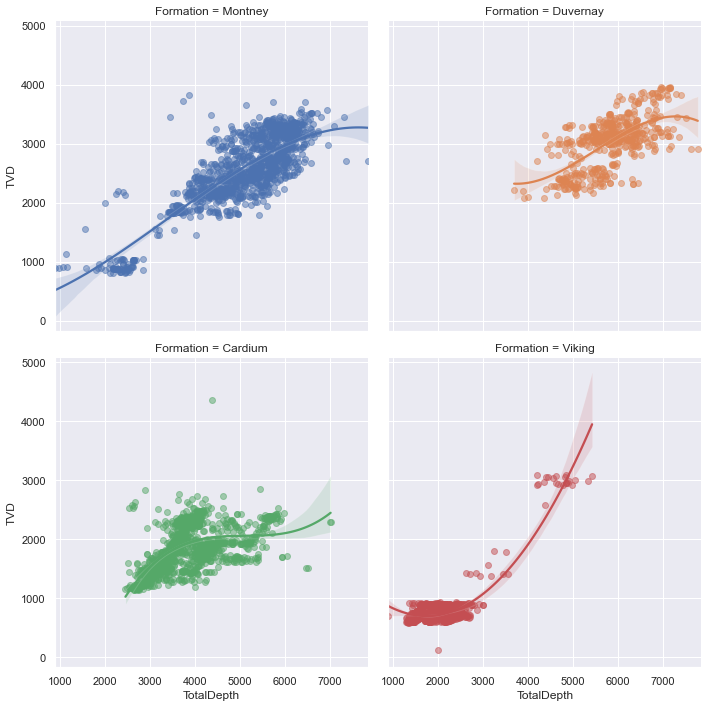

In [20]:
sns.set()
sns.lmplot( x="TotalDepth", y="TVD", data=well_header, 
            fit_reg=True,hue='Formation',legend=False,col="Formation",col_wrap=2, height=5,order=3,
            scatter_kws={'alpha':0.5});

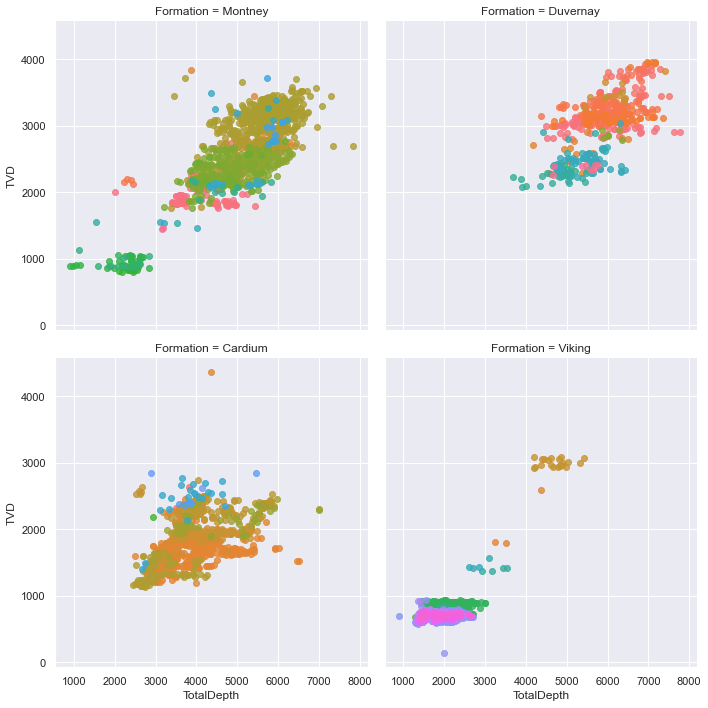

In [19]:
sns.set()
sns.lmplot( x="TotalDepth", y="TVD", data=well_header, 
            fit_reg=False,hue='Field',legend=False,col="Formation",col_wrap=2, height=5);

Distribution of TVD for horizontal vs directional wells

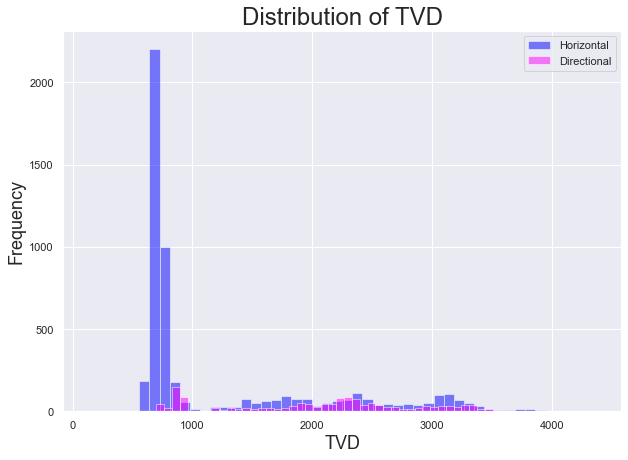

In [23]:
well_header[well_header['WellProfile']=="Horizontal"].TVD.plot(kind='hist',bins=50,color="blue",alpha=0.5,figsize=(10, 7))
well_header[well_header['WellProfile']=="Directional"].TVD.plot(kind='hist',bins=50,color="magenta",alpha=0.5,figsize=(10, 7))
plt.legend(labels=['Horizontal', 'Directional'])
plt.title('Distribution of TVD', size=24)
plt.xlabel('TVD', size=18)
plt.ylabel('Frequency', size=18);

In [ ]:
# taken from : 
#  https://stackoverflow.com/questions/47664061/how-to-apply-polynomial-transformation-to-subset-of-features-in-scikitlearn?rq=1


# estimators need to inherit from these classes to play nicely with others
class ColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_cols = X[self.columns]
        return X_cols

# Using pandas get dummies to make pipeline a bit simpler by
# avoiding one-hot and label encoder.     
# Build the pipeline from a FeatureUnion that processes 
# numerical and one-hot encoded separately.
# FeatureUnion puts them back together when it's done.
pipe2nvars = Pipeline([
    ('features', FeatureUnion([('num', 
                                Pipeline([('extract', 
                                           ColumnExtractor(columns=['TotalDepth'])),
                                          ('poly', 
                                           PolynomialFeatures())  ])),
                               ('cat_var', 
                                ColumnExtractor(columns=['Formation_Montney','Formation_Duvernay',
                                                         'Formation_Cardium','Formation_Viking']))])
    )])    

pipe2nvars.set_params(features__num__poly__degree=3)
X = pipe2nvars.fit_transform(pd.get_dummies(X, drop_first=False))

### (1) Linear Regression: Fit a model to the training set

### (3) Ridge regression: Fit a new regression model to the training set

### (2) Decision Tree Regressor: Fit a new regression model to the training set